## Notebook for Plant Type Allocation Model

What to expect:

1. RL environment for plant type allocation model
2. Creation of plant type allocation RL model
3. Training of plant type allocation model
4. Evaluation of plant type allocation model

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import gc
import random
from perlin_noise import PerlinNoise

import cv2
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label, center_of_mass

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

### Environment

In [3]:
class proceduralGeneratedEnv():
    def __init__(self, octave:float, seed:int, grid_size:tuple, minimum_distance:int, padded_boundary:int):
        """
        Class to randomly generate an environment using perlin noise and dithering

        Args:
            octave (float): octave value from range [1-2] for perlin noise
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
            minimum_distance (int): minimum distance between 2 planting coordinate
            padded_boundary (int): padded distance around the corners that will have no planting coordinate
        """
        self.octave = octave
        self.seed = seed
        self.grid_size = grid_size
        self.minimum_distance = minimum_distance
        self.padded_boundary = padded_boundary

    def create_environment(self):
        """
        Function to create an environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable (if random seed)
        Filters to ensure self.min_distance grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
            planting_grid (np.ndarray): self.grid_size grid of 0 for background and 1 for plantable coordinates (just the spot)
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array of all planting coordinates in (y,x) 
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= self.seed if self.seed is not None else random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Retrieve all planting positions
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            
            # Non pre-set seed, check to ensure 7.5% must be plantable, else ignore
            if self.seed != None or len(planting_positions) / len(dithered_perlin_env.flatten()) > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_boundary(perlin_env)
        planting_grid, planting_coords  = self._filter_planting_coords(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords
    
    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    
    def _extract_boundary(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the boundary of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        # For dilating, expanding the points so that they form a nice boundary blob
        kernel = np.ones((3,3), np.uint8) 
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    
    def _filter_planting_coords(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least self.minimum_distance apart
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        # numpy mask
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False

        # Apply mask to remove coordinates that are too close
        final_planting_coordinates = filtered_planting_positions[keep_array]
        
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        
        return final_grid, final_planting_coordinates    

In [4]:
class plantTypeAllocationEnv(gym.Env):
    def __init__(self, octave:float, theme:int, seed:int=None, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            theme (int): either 0 or 1, 0 for road while 1 for walkway
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
        """
        super(plantTypeAllocationEnv, self).__init__()

        # Step for environment termination
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5

        # Grid variables
        self.theme = theme
        self.seed = seed
        self.grid_size = grid_size

        # Create environment grid
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.env = proceduralGeneratedEnv(octave, seed, grid_size, self.minimum_distance, self.padded_boundary)
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()

        # Class Data
        # In y,x coordinates, need to be modified
        self.coordinates = {
            "Tree": [],
            "Shrubs" : []
        }
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Generate embedded coordinates & result grid
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()

        # Observation and Action Space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])

    def _embed_coordinates(self):
        """
        Function to convert planting coordinates into their respective embedding
        [xCoord, yCoord, coordDistance, nearCurve, remainingPlantableTrees, originalTreeScore, finalTreeScore, shrubScore, naScore]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1,-1,-1,-1)

        Returns:
            embed_planting_list (np.ndarray): Numpy array of all embeded planting cordinates and padded coordinates 
        """
        # Padded
        embed_planting_list = np.full(((self.maximum_planting_spots), 9), -1, dtype=np.float32)  # Initialize with (-1, -1, ...)
        curve_data = []

        # Get the distance from the boundary, used to measure if near curves
        distance_from_boundary_grid = distance_transform_edt(self.filled_boundary)

        if self.theme == 0:
            # Road
            grid_distance  = self._distance_from_centre()
        else:
            # Walkway
            grid_distance =  distance_from_boundary_grid

        # Minimum distance before can plant tree
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(self.planting_coordinates): #planting coords is (y,x)
            # Retrieve the coordinate distance & the contour line it lies on
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            # Retrieve the coordinate distance & contour line from the boundary
            if self.theme == 0:
                border_contour, border_dist = self._get_contour(distance_from_boundary_grid, planting_coords[1], planting_coords[0])
            else:
                border_contour, border_dist = contour, coord_dist
            curve_data.append([border_contour, border_dist])
            # Retrieve all remaining plantable trees after planting for this coordinate
            remaining_plantable_trees = self._get_remaining_plantable_tree_count(planting_coords[1], planting_coords[0])

            # Calculating the tree, shrub and NA scores
            tree_score = 2 if coord_dist >= min_tree_distance else -1 # Unplantable
            shrub_score = 2 
            na_score = 1 
            if self.theme == 0:
                # Road, shrub should be near center and not near boundary
                if border_contour <= 1:
                    shrub_score = 0
                    na_score = 3
                elif coord_dist <= min_tree_distance:
                    shrub_score = 3
            else:
                # Walkway, shrub is closer to boundary
                if border_contour <= 2:
                    shrub_score = 3
                    na_score = 0 

            # Update embeddings
            embed_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), border_dist, remaining_plantable_trees, tree_score, tree_score, shrub_score, na_score)

        # Calculate near curve (the idea behind it is if they are in the same contour line and distance, )
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        # Update near Curve
        embed_planting_list[:len(self.planting_coordinates), 3] = np.where(is_duplicate, 0, 1)
        
        # Update tree score, if near curve and tree score becomes 2 -> 3
        embed_planting_list[(embed_planting_list[:, 3] == 1) & (embed_planting_list[:, 5] == 2), 5] = 3
        # Sum the tree plantable & maximum plantable trees together
        embed_planting_list[:, 6] = np.where(
            embed_planting_list[:, 6] != -1,  # Condition: 6th index is not -
            embed_planting_list[:, 4] + embed_planting_list[:, 5],  # Valid log operation
            embed_planting_list[:, 6]  # Remains unchanged if 6th index is -1
        )
        
        self.result_grid = embed_planting_list[:, 6:]

        return embed_planting_list.astype(np.int64)

    def _distance_from_centre(self):
        """
        Function to create a numpy grid with each grid being the distance from the centre of planting grid

        Returns:
            distance_from_center (np.ndarray): Array with the distance from centre
        """
        # Retrieve the labels and number of features (either 0 or 1)
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component with elucidean distance
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        return distance_from_center

    def _get_contour(self, grid_distance:np.ndarray, xcoord:int, ycoord:int):
        """
        Function to retrieve the distance of a coordinate from the grid distance and the contour it belongs to

        Args:
            grid_distance (np.ndarray): numpy array with each coordinate showing the distance
            xcoord (int): x coordinate
            ycoord (int): y coordinate

        Returns:
            chosen_contour (int): contour coordinate belongs to
            coordinate_distance (float): distance of coordinate based off grid_distance
        """
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        return chosen_contour, coordinate_distance

    def _get_remaining_plantable_tree_count(self, xcoord:int, ycoord:int):
        """
        Function to retrieve the log number of remaining plantable trees that are self.tree_distance away from coordinate

        Args:
            xcoord (int):  x coordinate
            ycoord (int): y coordinate
        """
        # Get all current tree coordinates
        new_tree_coordinates = np.array(self.coordinates['Tree'] + [[ycoord, xcoord]])
        # Calculate the distance of all planting coordinates from existing tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        # Return all counts where the min_distance > self.tree_distances
        return np.log(np.sum(min_distances >= 50)) if np.sum(min_distances >= self.tree_distance) > 0 else 0
        
    # RL model environment setup
    def _get_observation(self):
        return self.result_grid
    
    def reset(self, seed=None, options=None):
        """
        Reset environment
        """
        self.current_step = 0
        self.coordinates = {
                    "Tree": [],
                    "Shrubs" : []
                }        
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()
        return self._get_observation() , {}
    
    def step(self, action):

        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.embeded_planting_coords[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            # Update coordinate values
            if class_value == 0:
                self.coordinates['Tree'].append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()   

            elif class_value == 1:
                self.coordinates['Shrubs'].append((chosen_value[1], chosen_value[0]))

            # Update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        done = bool(np.all(np.isin(self.result_grid[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    
    def _update_tree_distance(self):
        """
        Function to update which coordinates are now no longer plantable after planting a new tree coordinate
        """
        tree_coordinates = np.array(self.coordinates['Tree'])
        # Get distance from all planting coordinates to all tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < self.tree_distance:
                # No longer plantable
                # Update embedded_coordinates and result grid
                self.embeded_planting_coords[index][-4] = -1
                self.result_grid[index][0] = -1

        # Recalculate all new possible maximum tree planted after the tree coordinate update
        for index, result_row in enumerate(self.result_grid):
            if result_row[0] != -1:
                remaining_plantable_trees = self._get_remaining_plantable_tree_count(self.embeded_planting_coords[index][0], self.embeded_planting_coords[index][1])
                result_row[0] = remaining_plantable_trees + self.embeded_planting_coords[index][5] # Original Tree Score + new log(Max trees)
    
    def _update_density_reward(self):
        """
        Function to calculate the density reward
        """
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        # Shrub, NA ratio
        density_ratios = [0.65, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.embeded_planting_coords[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
    
    def retrieve_results(self):
        """
        Function the returns the coordinates and numpy grid of the map
        Map index:
        {
        0: surrounding
        1: planting areas
        2: trees
        3: shrub 
        }

        Returns:
            theme (int): 0 for road, 1 for walkway
            grid (np.npdarray): numpy array of the updated grid with planted coordinates
            coordinates (dict): dictionary of {Tree: [], Shrubs:[]} with all the coordinates
        """
        # Swap the (y,x) to (x,y) coordinates
        updated_coordinates = {key: [(x, y) for y, x in value] for key, value in self.coordinates.items()}
        updated_grid = self.filled_boundary.copy()
        # Append the correct coordinates to the grid
        for key, coordinates in updated_coordinates.items():
            for x, y in coordinates:
                # Set the value at the given (x, y) position in the array
                updated_grid[y, x] = 2 if key=='Tree' else 3
                
        return self.theme, updated_grid, updated_coordinates
    
    def render(self, only_plant:bool=False, show_coord:bool=False):
        """
        Function to render the grid

        Args:
            only_plant (bool, optional): Show only planted spots, NA is not shown. Defaults to False.
            show_coord (bool, optional): Show reward values. Defaults to False.
        """
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, d2, d3, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()

[84  1]
[ 6 38]


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


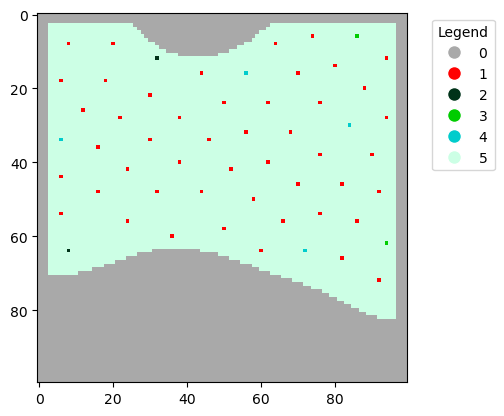

In [4]:
# Test to ensure environment works
test = plantTypeAllocationEnv(random.uniform(1,2), 0)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
check_env(test)
test.render()

### Model Training

In [5]:
def make_env(octave, theme):
    def _init():
        return plantTypeAllocationEnv(octave, theme)
    return _init

# Creating 300 test environments
envs = DummyVecEnv([make_env(random.uniform(1,2), 0) for env in range(10)])

In [ ]:
def make_env(octave, theme):
    def _init():
        return plantTypeAllocationEnv(octave, theme)
    return _init

# Creating 300 test environments
envs = DummyVecEnv([make_env(random.uniform(1,2), 0) for env in range(300)])

In [ ]:
# Initialising Model
gc.collect()
model = PPO("MlpPolicy", 
             envs, 
             n_steps= 10,
             n_epochs= 10,
             batch_size= 10 * 300,
             verbose=0,
             tensorboard_log="./ppo_spatial_tensorboard/")

In [7]:
# Initialising Callback 
# Callback will save the best model from eval_env
eval_env = plantTypeAllocationEnv(1.25, 0, 2)
eval_callback = EvalCallback(eval_env, best_model_save_path="../src/models/",
                            log_path="../src/logs/", eval_freq=10000,
                            deterministic=True, render=False)

In [ ]:
# Training Model
def train_model(model:PPO, max_run:int, n_steps:int, model_path:str, call_back=None, progress_bar:bool=True):
    """
    Function to train model

    Args:
        model (PPO): PPO model
        max_run (int): total number of policy updates model should take
        n_steps (int): n_steps for each policy update
        model_path (str): model path to save model after training
        call_back (optional): callback for model. Defaults to None.
        progress_bar (bool, optional): Show training progress bar. Defaults to True.
    """
    # Calculate total timesteps
    total_timesteps = max_run* n_steps
    # Train model
    model.learn(total_timesteps=total_timesteps, progress_bar=progress_bar, callback=call_back)
    # Save model
    model.save(model_path)
    print(f"Model saved to {model_path}.")

train_model(model, 1000000, 10, '../src/models/plantTypeAllocationModel.zip', eval_callback)

### Model Evaluation

In [5]:
from stable_baselines3 import PPO
model = PPO.load('../src/models/plantTypeAllocationModel.zip')

c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\cheng\\anaconda3\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(
c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'c:\\Users\\cheng\\anaconda3\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(


In [6]:
def eval_model(model:PPO, eval_env, show_results:bool=True, return_results:bool=True):
    """
    Function to evaluate model onto a defined environment

    Args:
        model (PPO): trained PPO model
        eval_env: environment to evaluate model on
        show_results (bool, optional): Render final grid. Defaults to True.
        return_results (bool, optional): Return the results (call environment.retrieve_results()). Defaults to True.
    """
    obs, info = eval_env.reset()
    total_reward = 0

    for i in range(eval_env.max_step):
        # Get action from the model
        action, _ = model.predict(obs)  # Get the predicted action
        obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
        total_reward += reward  # Accumulate rewards

        if done:
            break

    print(f"Model completed in {i} steps, total reward {total_reward}")
    if show_results:
        eval_env.render(True)
    if return_results:
        return eval_env.retrieve_results()

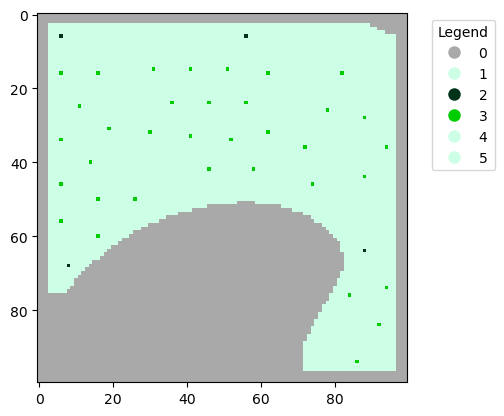

Model completed in 54 steps, total reward 35.978172197937965
0
{'Tree': [(56, 6), (6, 6), (88, 64), (8, 68)], 'Shrubs': [(56, 24), (62, 32), (30, 32), (14, 40), (19, 31), (84, 76), (92, 84), (6, 46), (86, 94), (74, 46), (94, 74), (26, 50), (88, 44), (58, 42), (6, 16), (94, 36), (62, 16), (41, 15), (16, 50), (16, 60), (6, 34), (72, 36), (31, 15), (6, 56), (78, 26), (46, 42), (51, 15), (52, 34), (41, 33), (82, 16), (36, 24), (11, 25), (16, 16), (88, 28), (46, 24)]}


In [7]:
eval_env = plantTypeAllocationEnv(1.25, 0, 2)
theme1, grid1, coordinates1 = eval_model(model, eval_env)
print(theme1)
print(coordinates1)

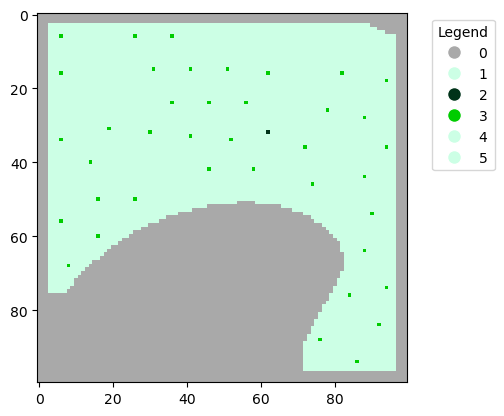

Model completed in 66 steps, total reward -1.253697644919157
1
{'Tree': [(62, 32)], 'Shrubs': [(30, 32), (16, 50), (86, 94), (88, 44), (74, 46), (6, 6), (90, 54), (76, 88), (56, 24), (94, 74), (14, 40), (19, 31), (16, 60), (92, 84), (8, 68), (58, 42), (62, 16), (46, 42), (6, 34), (72, 36), (78, 26), (41, 15), (51, 15), (31, 15), (84, 76), (94, 36), (26, 6), (26, 50), (6, 56), (82, 16), (52, 34), (41, 33), (36, 6), (88, 64), (6, 16), (36, 24), (94, 18), (88, 28), (46, 24)]}


In [42]:
eval_env2 = plantTypeAllocationEnv(1.25, 1, 2)
theme2, grid2, coordinates2 = eval_model(model, eval_env2)
print(theme2)
print(coordinates2)

### Mock Data Creation
For UI to test on

In [11]:
plant_id= {'Tree': [2964, 3343, 3052, 2788, 2829, 2887, 2821, 2879, 3106, 3200, 3138, 3077, 3344, 3372], 
           'Shrubs': [3740, 1783, 1593, 2132, 5062, 3427, 2381, 2185, 2829, 2217, 3739, 1507, 2504, 1676, 3443, 2267, 3372]
           }

In [12]:
import json
json_data = {"data": []}

In [ ]:
import matplotlib.image

data_value = 0
while True:
    
    eval_env = plantTypeAllocationEnv(random.uniform(1,2), random.randint(0,1))
    theme, grid, coordinates = eval_model(model, eval_env, False)

    data = {"data_value": data_value,
            "surrounding_context": "Road" if eval_env.theme == 0 else "Walkway",
            "grid": grid.tolist(),
            "grid_img_url": f"Grid_{data_value}.png",
            }


    num_trees = min(len(plant_id['Tree']), len(coordinates['Tree']), random.randint(3,4))
    num_shrubs = min(len(plant_id['Shrubs']), random.randint(4,6))

    selected_trees = random.sample(plant_id['Tree'], num_trees)
    selected_shrubs = random.sample(plant_id['Shrubs'], num_shrubs)

    tree_coordinates = coordinates['Tree']
    random.shuffle(tree_coordinates)

    coordinate_mapping = {coord: id for coord, id in zip(tree_coordinates[:len(selected_trees)], selected_trees)}

    for coords in tree_coordinates[len(selected_trees):]:
        coordinate_mapping[coords] = random.choice(selected_shrubs)

    shrub_coordinates = coordinates['Shrubs']
    random.shuffle(shrub_coordinates)

    shrub_coordinate_mapping = {coord: id for coord, id in zip(shrub_coordinates[:len(selected_shrubs)], selected_shrubs)}

    for coords in shrub_coordinates[len(selected_shrubs):]:
        shrub_coordinate_mapping[coords] = random.choice(selected_shrubs)
    
    coordinate_mapping.update(shrub_coordinate_mapping)

    data['coordinates'] = coordinate_mapping

    json_data["data"].append(data)
    matplotlib.image.imsave(f"Grid_{data_value}.png", grid)

    plant_id['Tree'] = list(set(plant_id['Tree']) - set(selected_trees))
    plant_id['Shrubs'] = list(set(plant_id['Shrubs']) - set(selected_shrubs))

    data_value+= 1
    if len(plant_id['Tree']) == 0:
        break

    if len(plant_id['Shrubs']) == 0:
        plant_id['Shrubs'] = [3740, 1783, 1593, 2132, 5062, 3427, 2381, 2185, 2829, 2217, 3739, 1507, 2504, 1676, 3443, 2267, 3372]

    

Model completed in 60 steps, total reward 9.071605361998081
Model completed in 75 steps, total reward 35.477816458791494
Model completed in 64 steps, total reward 35.45284017547965
Model completed in 46 steps, total reward 4.616623155772686
Model completed in 54 steps, total reward 32.79771273583174


In [15]:
import json

jsonData = json.dumps(json_data)

TypeError: Object of type ndarray is not JSON serializable